# &nbsp; Supervised ML: Predicting housing prices (Phase2: Regression)
- Iteration 7: feature selection (manually)

Feature selection is aimed at identifying and selecting the most relevant and informative features from a given dataset. With the abundance of available features, selecting the right subset of variables can significantly impact the model's performance. By pruning irrelevant or redundant features, feature selection not only enhances the accuracy and generalisation capabilities of models but also reduces computational complexity, ensuring faster and more efficient predictions.

## 1.&nbsp; Import libraries 💾

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFECV, SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error , root_mean_squared_error

In [2]:
# 0. Set the config so that we can view our preprocessor, and to transform output from numpy arrays to pandas dataframes
set_config(display="diagram")
set_config(transform_output="pandas")

## 2.&nbsp; Data reading 📂

In [3]:
# reading: housing_iteration_6_regression
url = "https://drive.google.com/file/d/1mOYOiWuqCybgAsb4l9pJONJKVBcyDFu-/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

housing_data = pd.read_csv(path)

In [4]:
housing_data.shape

(1460, 81)

In [5]:
housing_data.sample(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
80,81,60,RL,100.0,13000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,193500
1314,1315,20,RL,60.0,8190,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,WD,Normal,119000
707,708,120,RL,48.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,254000


In [6]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## 3.&nbsp; Train-test split 🔀

All data transformations and feature selection should rely solely on the information from the training set, with no consideration of the test set. In feature selection, this involves deciding the usefulness of columns based only on the training set. Once we identify which columns to drop, we apply the same removal to the test set as well. 
> For custom feature selection without SKLearn, it is vital to adhere to this principle of excluding any information from the test set during the feature selection process.

In [7]:
X = housing_data.drop(columns=["Id"])
y = X.pop("SalePrice")

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

## 4.&nbsp;Baseline Model 🧱

Here, we will focus on comparing the performance of two baseline models: Decision Tree and K-Nearest Neighbors model. After applying each model, we will track and evaluate the feature selection to understand their impact on the predictive performance.

In [9]:
# 1. defining categorical & numerical columns
X_cat = X_train.select_dtypes(exclude="number").copy()
X_num = X_train.select_dtypes(include="number").copy()

# 2. numerical pipeline
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"), MinMaxScaler())

# 3. categorical pipeline

# # 3.1 defining ordinal & onehot columns
# .get_indexer() get's the index to solve the problem described above about losing column names
ordinal_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
                "BsmtExposure", "BsmtFinType1", "KitchenQual", 
                "FireplaceQu", "GarageFinish", "GarageQual", 
                "GarageCond", "PavedDrive", "LotShape", "Utilities", 
                "LandSlope", "BsmtFinType2", "HeatingQC"]
onehot_cols = ["MSZoning", "Condition1", "Heating", "Street", 
               "CentralAir", "Foundation", "GarageType", "SaleType", 
               "SaleCondition", "LandContour", "LotConfig", 
               "Neighborhood", "Condition2", "BldgType", "HouseStyle", 
               "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
               "Electrical", "Functional"]

# # 3.2. defining the categorical encoder

# # # 3.2.1. we manually establish the order of the categories for our ordinal features, from less important to the most important and including "N_A"
ExterQual_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_cats = ["N_A", "No", "Mn", "Av", "Gd"]
BsmtFinType1_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
KitchenQual_cats = ["Po", "Fa", "TA", "Gd", "Ex"]
FireplaceQu_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageFinish_cats = ["N_A", "Unf", "RFn", "Fin"]
GarageQual_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageCond_cats = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
PavedDrive_cats = ["N", "P", "Y"]
LotShape_cats = ["IR3", "IR2", "IR1", "Reg"]
Utilities_cats = ["ELO", "NoSeWa", "NoSewr", "AllPub"]
LandSlope_cats = ["Sev", "Mod", "Gtl"]
BsmtFinType2_cats = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
HeatingQC_cats = ["Po", "Fa", "TA", "Gd", "Ex"]

# # # 3.2.2. defining the categorical encoder: a ColumnTransformer with 2 branches: ordinal & onehot
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(
            categories=[ExterQual_cats, ExterCond_cats, BsmtQual_cats, 
                        BsmtCond_cats, BsmtExposure_cats, 
                        BsmtFinType1_cats, KitchenQual_cats, 
                        FireplaceQu_cats, GarageFinish_cats, 
                        GarageQual_cats, GarageCond_cats, 
                        PavedDrive_cats, LotShape_cats, Utilities_cats, 
                        LandSlope_cats, BsmtFinType2_cats, 
                        HeatingQC_cats], handle_unknown="use_encoded_value", unknown_value= 10), ordinal_cols),
        ("cat_onehot", OneHotEncoder(
            handle_unknown="ignore", sparse_output=False), onehot_cols),
    ]
)

# # 3.3. categorical pipeline = "N_A" imputer + categorical encoder
categorical_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"), 
        categorical_encoder,
        MinMaxScaler()
        )

# 4. full preprocessing: a ColumnTransformer with 2 branches: numeric & categorical
full_preprocessing = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categorical_pipe, X_cat.columns),
    ]
)

full_preprocessing

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFull...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

In [10]:
X_train_encoded = full_preprocessing.fit_transform(X_train)

In [11]:
X_train_encoded

,num_pipe__MSSubClass,num_pipe__LotFrontage,num_pipe__LotArea,num_pipe__OverallQual,num_pipe__OverallCond,num_pipe__YearBuilt,num_pipe__YearRemodAdd,num_pipe__MasVnrArea,num_pipe__BsmtFinSF1,num_pipe__BsmtFinSF2,...,cat_pipe__cat_onehot__Electrical_FuseP,cat_pipe__cat_onehot__Electrical_Mix,cat_pipe__cat_onehot__Electrical_N_A,cat_pipe__cat_onehot__Electrical_SBrkr,cat_pipe__cat_onehot__Functional_Maj1,cat_pipe__cat_onehot__Functional_Maj2,cat_pipe__cat_onehot__Functional_Min1,cat_pipe__cat_onehot__Functional_Min2,cat_pipe__cat_onehot__Functional_Mod,cat_pipe__cat_onehot__Functional_Typ
318,0.235294,0.236301,0.040197,0.666667,0.500,0.876812,0.716667,0.218803,0.174876,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
580,0.000000,0.166384,0.062095,0.555556,0.625,0.637681,0.616667,0.072650,0.105245,0.148575,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
961,0.235294,0.166384,0.051074,0.555556,0.750,0.760870,0.750000,0.362393,0.158753,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
78,0.411765,0.174658,0.044301,0.333333,0.500,0.695652,0.300000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.176471,0.219178,0.059899,0.444444,0.500,0.876812,0.750000,0.000000,0.129695,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,0.235294,0.166384,0.036598,0.555556,0.875,0.681159,0.833333,0.215385,0.070872,0.043419,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1122,0.000000,0.166384,0.035645,0.333333,0.250,0.608696,0.100000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1346,0.000000,0.166384,0.091056,0.666667,0.750,0.695652,0.883333,0.000000,0.052622,0.046133,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1406,0.382353,0.167808,0.033396,0.444444,0.750,0.724638,0.950000,0.000000,0.116230,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### 4.1.&nbsp; Decision Tree Regressor

In [14]:
dt_full_pipeline_GS = make_pipeline(full_preprocessing, 
                                 DecisionTreeRegressor())

# The parameter grid for the regressor
param_grid_dt = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "columntransformer__num_pipe__simpleimputer__fill_value": [10],
    "decisiontreeregressor__max_depth": range(10, 30, 5),
    "decisiontreeregressor__min_samples_split": [2, 3, 4],
    "decisiontreeregressor__min_samples_leaf": range(2, 5)
}

dt_search = GridSearchCV(
    dt_full_pipeline_GS,
    param_grid_dt,
    cv=5,
    verbose=1,
    scoring="r2"
)

# Fitting the pipeline to the training data
dt_search.fit(X_train, y_train)

# Get the best R² score and parameters
best_r2 = dt_search.best_score_
best_params = dt_search.best_params_

# Output results
scores_dt = {
    "best_r2": best_r2,
    "best_params": best_params
}

scores_dt



Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'best_r2': np.float64(0.7538867150627593),
 'best_params': {'columntransformer__num_pipe__simpleimputer__fill_value': 10,
  'columntransformer__num_pipe__simpleimputer__strategy': 'median',
  'decisiontreeregressor__max_depth': 10,
  'decisiontreeregressor__min_samples_leaf': 3,
  'decisiontreeregressor__min_samples_split': 4}}

In [15]:
dt_search.feature_names_in_

#dt_search.get_feature_names_out()

array(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDriv

In [16]:
# Predict on the test set
y_pred_dt = dt_search.predict(X_test)

In [27]:
assessment_df = pd.DataFrame(columns=['MAE', 'RMSE', "MAPE","R2_score"])
assessment_df.loc['Decision Tree','MAE'] = mean_absolute_error(y_true = y_test, y_pred = y_pred_dt)
assessment_df.loc['Decision Tree','RMSE'] = root_mean_squared_error(y_true = y_test, y_pred = y_pred_dt)
assessment_df.loc['Decision Tree','MAPE'] = mean_absolute_percentage_error(y_true = y_test, y_pred = y_pred_dt)
assessment_df.loc['Decision Tree','R2_score'] = r2_score(y_true = y_test, y_pred = y_pred_dt)

In [28]:
assessment_df

,MAE,RMSE,MAPE,R2_score
Decision Tree,24954.621316,42116.560331,0.135666,0.712959


### 4.2.&nbsp; K Nearest Neighbors Regressor

In [23]:
knn_full_pipeline_GS = make_pipeline(full_preprocessing, 
                                 KNeighborsRegressor())

# The parameter grid for the regressor
param_grid_knn = {
    "columntransformer__num_pipe__simpleimputer__strategy": ["mean", "median"],
    "columntransformer__num_pipe__simpleimputer__fill_value": [10],
    "kneighborsregressor__n_neighbors": range(2, 50, 2),
    "kneighborsregressor__weights": ["uniform", "distance"],
    "kneighborsregressor__leaf_size": range(1, 30, 5)
}

knn_search = GridSearchCV(
    knn_full_pipeline_GS,
    param_grid_knn,
    cv=5,
    verbose=1,
    scoring="r2"
)

# Fitting the pipeline to the training data
knn_search.fit(X_train, y_train)

# Get the best score and parameters
best_r2 = knn_search.best_score_
best_params = knn_search.best_params_

# Output results
scores_knn = {
    "best_r2": best_r2,
    "best_params": best_params
}

scores_knn

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


{'best_r2': np.float64(0.6956323423774793),
 'best_params': {'columntransformer__num_pipe__simpleimputer__fill_value': 10,
  'columntransformer__num_pipe__simpleimputer__strategy': 'mean',
  'kneighborsregressor__leaf_size': 1,
  'kneighborsregressor__n_neighbors': 8,
  'kneighborsregressor__weights': 'distance'}}

Making predictions:

In [24]:
# Predict on the test set
y_pred_knn = knn_search.predict(X_test)

In this evaluation, we will utilise R-squared to assess our models' performance and gauge the impact of our feature selection process. While having a primary metric is recommended, exploring multiple metrics can provide diverse insights into the model's behavior. Therefore, feel free to explore alternative evaluation metrics to gain a more comprehensive understanding of your model's strengths and weaknesses.

In [29]:
assessment_df.loc['K Neighbors','MAE'] = mean_absolute_error(y_true = y_test, y_pred = y_pred_knn)
assessment_df.loc['K Neighbors','RMSE'] = root_mean_squared_error(y_true = y_test, y_pred = y_pred_knn)
assessment_df.loc['K Neighbors','MAPE'] = mean_absolute_percentage_error(y_true = y_test, y_pred = y_pred_knn)
assessment_df.loc['K Neighbors','R2_score'] = r2_score(y_true = y_test, y_pred = y_pred_knn)

In [30]:
assessment_df

,MAE,RMSE,MAPE,R2_score
Decision Tree,24954.621316,42116.560331,0.135666,0.712959
K Neighbors,27889.113725,44463.870311,0.152491,0.680071


You can already see how a Decision Tree handles a noisy dataset much better than K-Nearest Neighbors. Decision Trees selectively consider only the "best" features in the algorithm, while K-Nearest Neighbors treats all features equally. However, it's essential to remember that the Decision Tree might not always be the better choice; after feature selection, K-Nearest Neighbors could potentially perform better.

> **Note:** A negative R-squared score suggests that the KNN model performs worse than a horizontal line, indicating that it fails to capture any meaningful relationships between the input features and the target variable.

## 5.&nbsp;Feature selection based only on features 🔨

### 5.1.&nbsp;Variance Threshold

Features with low variance carry limited information, and with this transformer, we can eliminate those features by setting a threshold. Any feature with a variance below this threshold will be dropped from the dataset. It's essential to consider that column variance is influenced by its scale.

Let's first look at the range and variance of the columns.

Since, we have categorical columns, we need to use the encoded dataset:

In [31]:
X_train_encoded = full_preprocessing.fit_transform(X_train)

In [32]:
range_var_df = (pd.DataFrame({
                'Range': X_train_encoded.max() - X_train_encoded.min(),
                'Variance': X_train_encoded.var()})
                .sort_values(by='Variance'))

In [43]:
range_var_df.head(20)

,Range,Variance
cat_pipe__cat_onehot__Exterior2nd_CBlock,1.0,0.000856
cat_pipe__cat_onehot__Exterior1st_CBlock,1.0,0.000856
cat_pipe__cat_onehot__Condition2_RRAe,1.0,0.000856
cat_pipe__cat_onehot__Heating_Floor,1.0,0.000856
cat_pipe__cat_onehot__Condition2_PosA,1.0,0.000856
cat_pipe__cat_onehot__Electrical_Mix,1.0,0.000856
cat_pipe__cat_onehot__RoofMatl_Membran,1.0,0.000856
cat_pipe__cat_onehot__Condition2_RRAn,1.0,0.000856
cat_pipe__cat_onehot__RoofMatl_Roll,1.0,0.000856
cat_pipe__cat_onehot__Neighborhood_Blueste,1.0,0.000856


In [34]:
range_var_df.tail()

,Range,Variance
cat_pipe__cat_onehot__Exterior1st_VinylSd,1.0,0.228002
cat_pipe__cat_onehot__GarageType_Attchd,1.0,0.239115
cat_pipe__cat_onehot__Foundation_PConc,1.0,0.245864
cat_pipe__cat_onehot__Foundation_CBlock,1.0,0.246619
cat_pipe__cat_onehot__HouseStyle_1Story,1.0,0.250196


We have already scaled our data using the ``MinMaxScaler``. Scaling is crucial in this context because we are evaluating features based on variance, and larger variances may simply result from wider value ranges. Additionally, using an improper scaler (like ``StandardScaler``, which changes the standard deviation to 1) can make direct comparisons of column variances across different features less meaningful due to differences in scale. 

**Therefore, scaling the features before removing those with the smallest variance is a necessary step.**

Now, we can proceed with applying the `VarianceThreshold` transformation.

All features with a smaller variance than the `threshold` will be deleted from the dataset.

In [37]:
VarianceThreshold(threshold=0.01)

VarianceThreshold(threshold=0.01)

In [44]:
selector = VarianceThreshold(threshold=0.001)

X_train_var = selector.fit_transform(X_train_encoded)

Let's check how many features were dropped:

In [45]:
print("shape before:", X_train_encoded.shape)
print("shape after:", X_train_var.shape)

shape before: (1168, 215)
shape after: (1168, 199)


We have dropped `16` features using a threshold of `0.001`. We can adjust the threshold if to drop more or fewer features.

> **Note:** It's generally not advisable to drop many features with this transformer, as some features might contain crucial information, even if they have low variance. For instance, consider a feature in the Housing dataset representing the number of "Private Helicopters." Though it may have a small variance due to most houses having `0` helicopters, the presence of one helicopter can significantly impact the house price. Hence, it's essential to be cautious when dropping features, and it is usually safe to remove only features with zero variance as they offer no valuable information.

The next step: make sure to transform the test set using the `transform` method. Remember to avoid using the `fit_transform` method, as it is reserved exclusively for the train set. This way, you ensure proper feature scaling without introducing data leakage from the test set into the model.

In [60]:
X_num_train = X_train.select_dtypes(include="number").copy()

In [61]:
selector = VarianceThreshold(threshold=0.001)

X_train_var_num = selector.fit_transform(X_num_train)

In [62]:
X_num_test = X_test.select_dtypes(include="number").copy()

In [63]:
# Initialize the scaler.
my_scaler = MinMaxScaler().set_output(transform="pandas")

# Fit the scaler to X_train and transform the values.
X_train_scaled = my_scaler.fit_transform(X_train_var_num)

In [64]:
# Scale the test set
X_test_scaled = my_scaler.transform(X_num_test)

# Apply the variance threshold to the scaled test set
X_test_var = selector.transform(X_test_scaled)

Let's check how well our model performs with the new dataset.

In [74]:
# Decision tree.
var_tree = DecisionTreeRegressor()
var_tree.fit(X_train_scaled, y_train)
var_tree_pred = var_tree.predict(X_test_var)

# K-Nearest Neighbors.
#var_knn = KNeighborsRegressor(n_neighbors=1)
#var_knn.fit(X_train_var, y_train)
#var_knn_pred = var_knn.predict(X_test_var)

assessment_df.loc["Decision Tree varThreshold_0_001", "MAE"] = mean_absolute_error(y_test, var_tree_pred)
assessment_df.loc["Decision Tree varThreshold_0_001", "RMSE"] = root_mean_squared_error(y_test, var_tree_pred)
assessment_df.loc["Decision Tree varThreshold_0_001", "MAPE"] = mean_absolute_percentage_error(y_test, var_tree_pred)
assessment_df.loc["Decision Tree varThreshold_0_001", "R2_score"] = r2_score(y_test, var_tree_pred)

assessment_df

,MAE,RMSE,MAPE,R2_score
Decision Tree,24954.621316,42116.560331,0.135666,0.712959
K Neighbors,27889.113725,44463.870311,0.152491,0.680071
Decision Tree varThreshold_0_001,25911.554795,38951.158648,0.146815,0.754484


> KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values.

### 5.2.&nbsp; Collinearity

Features that have a perfect (or extremely high) correlation with each other can be considered to be the same feature. We want to drop one of them. Let's first explore the pairwise correlations between all features.

To quickly identify highly correlated columns, we can create a heatmap displaying their correlations, allowing us to easily spot extreme values.

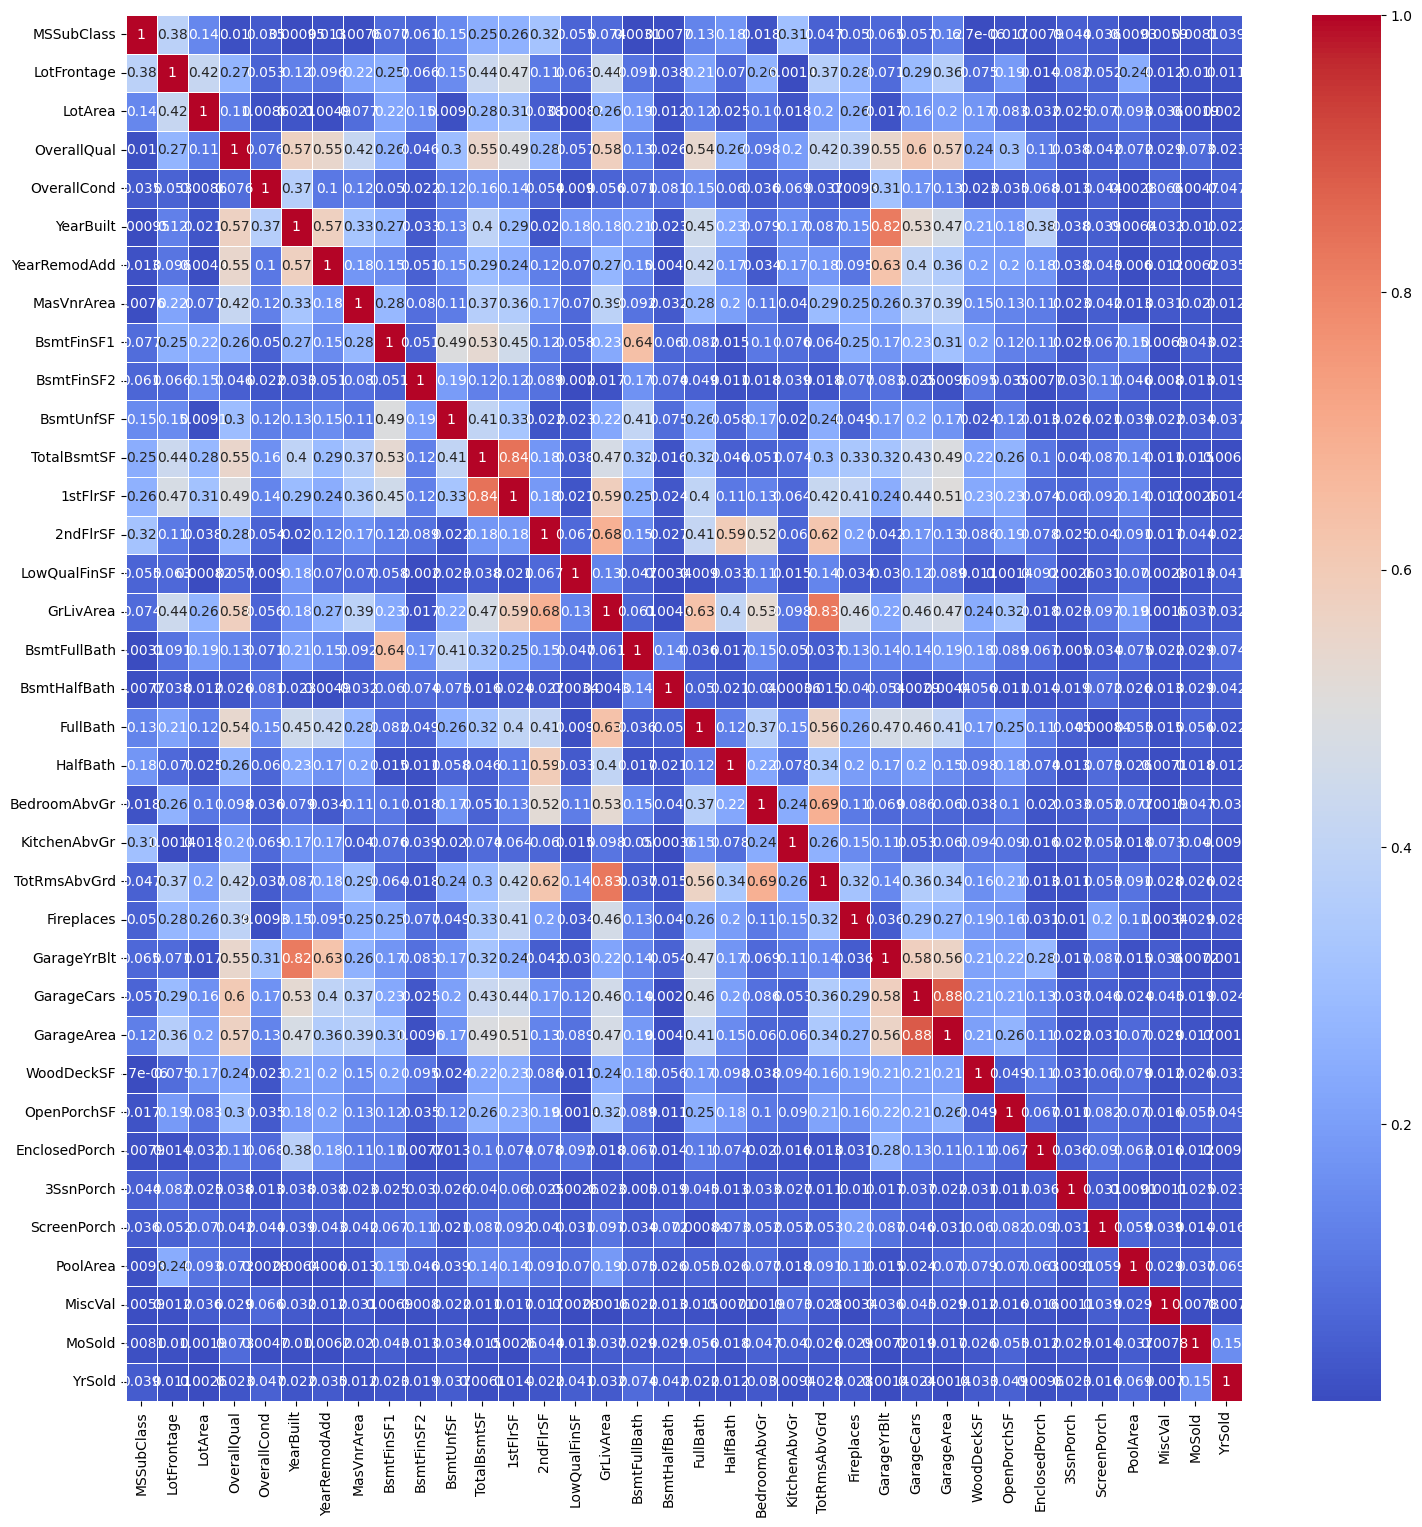

In [76]:
# Calculate the absolute correlation matrix for the feature matrix X_train_var2
corrMatrix = X_num.corr().abs()

# Set the size of the heatmap to be 18x18 inches
plt.figure(figsize=(18, 18))

# Create a heatmap using Seaborn (sns) to visualize the correlation matrix
# 'annot=True' adds the correlation values to the cells for better readability
# 'cmap='coolwarm'' specifies the color map to be used, with warm colors (red) for positive correlations
# and cool colors (blue) for negative correlations
# 'linewidths' sets the width of the white lines around the squares
sns.heatmap(corrMatrix,
            annot=True,
            cmap='coolwarm',
            linewidths=0.5);

From the heatmap we can see how there is a pair of columns with a very high correlation (`0.88` and `0.84`). The rest of the correlation coefficients are much smaller and can be neglected at this stage.

If you have too many column to view on a heatmap, we can loop through the columns to identify the correlated columns.

In [77]:
# Set the correlation threshold to consider columns as highly correlated
correlation_threshold = 0.83

# Initialise an empty list to store the pairs of highly correlated columns
highly_correlated_columns = []

# Get the number of features (columns) in the correlation matrix
num_features = len(corrMatrix.columns)

# Loop through the upper triangle of the correlation matrix to find highly correlated columns
# Note: We start from i+1 to avoid redundancy as correlation_matrix is symmetric
for i in range(num_features):
    for j in range(i + 1, num_features):
        # Check if the correlation value between columns i and j is greater than or equal to the threshold
        if corrMatrix.iloc[i, j] >= correlation_threshold:
            # Append the tuple (column_i, column_j) to the list of highly correlated columns
            highly_correlated_columns.append((corrMatrix.columns[i], corrMatrix.columns[j], f"correlation = {round(corrMatrix.iloc[i, j], 2)}"))

# Print the pairs of highly correlated columns
print("Highly correlated columns:", highly_correlated_columns)

Highly correlated columns: [('TotalBsmtSF', '1stFlrSF', 'correlation = 0.84'), ('GarageCars', 'GarageArea', 'correlation = 0.88')]


Since each tuple in our list contains 2 columns, we need to ensure we drop only one of them.

In [78]:
to_drop = [element_a for element_a, element_b, element_c in highly_correlated_columns]
to_drop

['TotalBsmtSF', 'GarageCars']

After identifying the columns to drop, we proceed to remove them from both the train and the test sets.
> **Note:** This is normally done outside of the pipeline; with correlation it's hard to include a custom function in the pipeline using [Function Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). This is hard to do as it normally removes different columns from the train and test set. The best solution to this is to create a class and include fit and tranform methods in the class. 

In [79]:
# Drop the columns from the train set.
X_train_corr = X_num.drop(columns=to_drop).copy()

# Drop the columns from the test set.
X_test_corr = X_num_test.drop(columns=to_drop).copy()

Let's check the performance again:

In [85]:
# Decision tree.
corr_tree = DecisionTreeRegressor()
corr_tree.fit(X_train_corr, y_train)
corr_tree_pred = corr_tree.predict(X_test_corr)

# K-Nearest Neighbors.
#corr_knn = KNeighborsRegressor(n_neighbors=1)
#corr_knn.fit(X_train_corr, y_train)
#corr_knn_pred = corr_knn.predict(X_test_corr)

assessment_df.loc["Decision Tree collinearity", "MAE"] = mean_absolute_error(y_test, corr_tree_pred)
assessment_df.loc["Decision Tree collinearity", "RMSE"] = root_mean_squared_error(y_test, corr_tree_pred)
assessment_df.loc["Decision Tree collinearity", "MAPE"] = mean_absolute_percentage_error(y_test, corr_tree_pred)
assessment_df.loc["Decision Tree collinearity", "R2_score"] = r2_score(y_test, corr_tree_pred)

assessment_df

,MAE,RMSE,MAPE,R2_score
Decision Tree,24954.621316,42116.560331,0.135666,0.712959
K Neighbors,27889.113725,44463.870311,0.152491,0.680071
Decision Tree varThreshold_0_001,25911.554795,38951.158648,0.146815,0.754484
Decision Tree collinearity,27069.017123,40548.849556,0.154342,0.73393


We observe that collinearity had a minor impact compared to the baseline model and variance threshold had the best impact so far.